Our simulated differential drive robot has a camera, so a lot of the code here is support for some computer vision.

In [ ]:
#| default_exp diffdrive

In [ ]:
#| include: false
from fastcore.all import *

In [ ]:
#| export
import gtsam
import math
import PIL
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

## Pinhole Figures

Some plotting support code to illustrate the pinhole camera model.

In [ ]:
#| export
def axes(length=1.5):
    """Add axes to a plotly figure"""
    return [
        go.Scatter3d(x=[0,length], y=[0,0], z=[0,0], mode="lines", line=dict(color="red")),
        go.Scatter3d(x=[0,0], y=[0,length], z=[0,0], mode="lines", line=dict(color="green")),
        go.Scatter3d(x=[0,0], y=[0,0], z=[0,length], mode="lines", line=dict(color="blue")),
        go.Scatter3d(x=[0], y=[0], z=[0], mode="markers", marker=dict(size=3, color="cyan")),
    ]

def plane(Z:float):
    return [
            go.Scatter3d(x=[-1.2, 1.2], y=[-1,-1], z=[Z, Z], mode="lines", line=dict(color="blue")), 
            go.Scatter3d(x=[-1.2, 1.2], y=[ 1, 1], z=[Z, Z], mode="lines", line=dict(color="blue")), 
            go.Scatter3d(x=[-1.2,-1.2], y=[-1, 1], z=[Z, Z], mode="lines", line=dict(color="blue")), 
            go.Scatter3d(x=[ 1.2, 1.2], y=[-1, 1], z=[Z, Z], mode="lines", line=dict(color="blue")), 
    ]

def ray(point3, F, color="orange"):
    X,Y,Z = point3
    x,y = F*X/Z, F*Y/Z
    return go.Scatter3d(x=[X,0,x], y=[Y,0,y], z=[Z,0,F], marker=dict(size=3, color=color))

def show_3d(fig):
    camera = dict(up=dict(x=0, y=-1, z=0), center=dict(x=0, y=0, z=0), eye=dict(x=1.7, y=-0.3, z=-1.1))
    fig.update_layout(scene_camera=camera, margin=dict(t=0, r=0, l=0, b=0), title="Pinhole Camera Model", showlegend=False)
    fig.show()

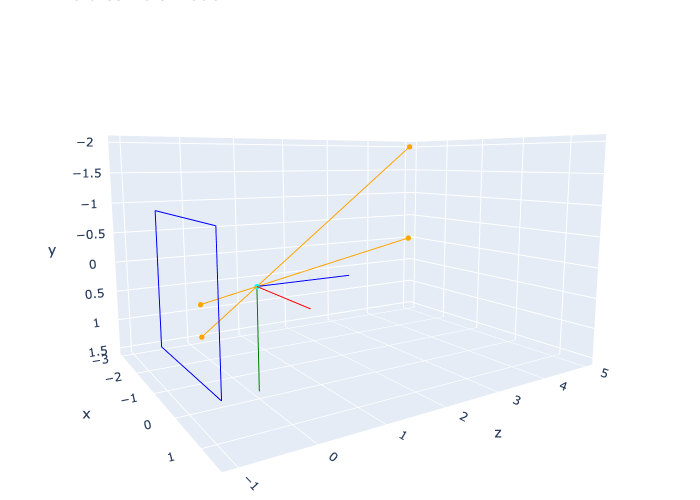

In [ ]:
pio.renderers.default = "png"
feet = gtsam.Point3(-3,0,5) # point at the feet of the person, 5 meters in front of camera, 3 meters to the left
head = gtsam.Point3(-3,-2,5) # point at the top of the head (note, Y = *minus* 2 meters)
F = 1 # meter
show_3d(go.Figure(data = plane(-F) + [ray(feet, -F), ray(head, -F)] + axes()))

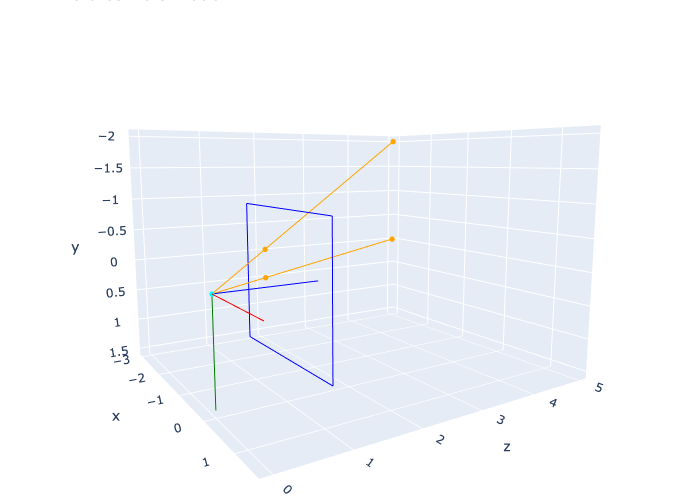

In [ ]:
show_3d(go.Figure(data = plane(F) + [ray(feet, F), ray(head, F)] + axes()))

## Reading Images

In [ ]:
#| export
import PIL
import requests

In [ ]:
#| export
def read_image(image_name):
    """Read image from a the book repo"""
    url = f"https://raw.githubusercontent.com/gtbook/robotics/main/Figures5/{image_name}"
    return PIL.Image.open(requests.get(url, stream=True).raw)

In [ ]:
image_name = "LL_color_1201754063.387872.bmp"
image = read_image(image_name) # locally: PIL.Image.open(image_name)
print(f"resolution = {image.width}x{image.height}")

resolution = 512x384


In [ ]:
import matplotlib.pyplot as plt

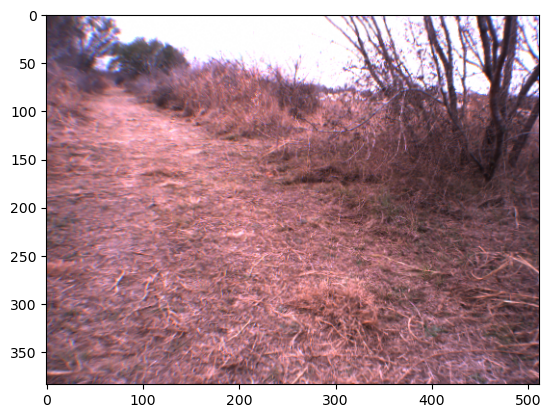

In [ ]:
plt.imshow(image);

In [ ]:
from PIL import ImageOps


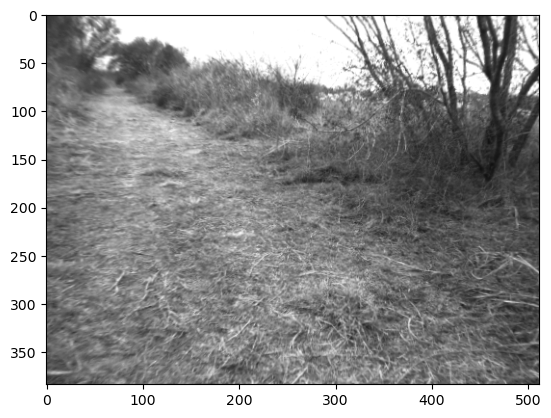

In [ ]:
grayscale_image = PIL.ImageOps.grayscale(image)
plt.imshow(grayscale_image, cmap="gray");

## Easy Convolution

In [ ]:
#| export
import torch

def conv2(input, filter):
    """Convolve input image of shape (iW,iH) with filter of shape (kW,kH)"""
    iW, iH = input.shape
    kW, kH = filter.shape
    _input = torch.reshape(input, (1, 1, iW, iH))
    _filter = torch.reshape(filter, (1, 1, kW, kH))
    _output = torch.conv2d(_input, _filter, padding='same')
    return torch.reshape(_output, (iW, iH))

In [ ]:
grayscale = torch.from_numpy(np.asarray(grayscale_image, dtype=float))
print(f"type={type(grayscale)}, dtype={grayscale.dtype}, shape={grayscale.shape}")
filter = torch.tensor([[-1.0, 0.0, 1.0]], dtype=float)
filter.shape

type=<class 'torch.Tensor'>, dtype=torch.float64, shape=torch.Size([384, 512])


torch.Size([1, 3])

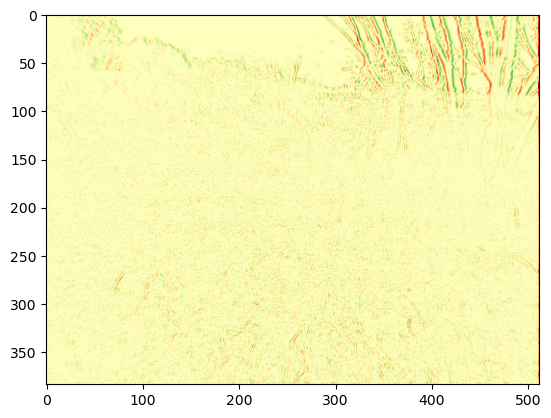

In [ ]:
vertical_edges = conv2(grayscale, filter)
plt.imshow(vertical_edges, cmap="RdYlGn");